In [ ]:
import pandas as pd
import numpy as np
from config import TOKEN

%run data_load.py

if final_json_data:
    for dict in final_json_data:
        # flatten the data
        bus_row = pd.json_normalize(dict) 
        
        # append the new row to data frame
        businesses = pd.concat([businesses, bus_row])
if not businesses.empty:
    # yelp likes to return duplicates 
    businesses = businesses.drop_duplicates(subset = ['id'])

    # make a new row for each dictionary in the categories col
    bus_exploded = businesses.explode('categories').reset_index(drop=True)

    # encode all the information into new binary categorical columns 
    bus_encoded = pd.get_dummies(bus_exploded['categories'].apply(pd.Series))

    # concat the new columns to the exploded dataframe so that the rows match
    bus_final = pd.concat([bus_exploded, bus_encoded], axis=1)

    # change all column names to string
    bus_final.columns = bus_final.columns.map(str)

    # drop the titles
    bus_final = bus_final.loc[:,~bus_final.columns.str.startswith('title')]

    # need to make the rows unique and get the sum of alias cols by partitioning by business id 
    grouped = bus_final.groupby('id')

    # Use 'transform' to calculate the sum of 'value1' and 'value2' within each group
    for col in bus_final.columns[25:]:
        bus_final[col[6:]] = grouped[col].transform('sum')
    bus_final = bus_final.drop_duplicates(subset = ['id'])



    # make a new row for each dictionary in the transaction col
    bus_exploded = bus_final.explode('transactions').reset_index(drop=True)

    # encode all the information into new binary categorical columns 
    bus_encoded = pd.get_dummies(bus_exploded['transactions'].apply(pd.Series))

    # concat the new columns to the exploded dataframe so that the rows match
    bus_final = pd.concat([bus_exploded, bus_encoded], axis=1)

    grouped = bus_final.groupby('id')

    # Use 'transform' to calculate the sum of 'value1' and 'value2' within each group
    for col in bus_final.columns[-3:]:
        bus_final[col[2:]] = grouped[col].transform('sum')
    bus_final = bus_final.drop_duplicates(subset = ['id'])


    # clean up
    bus_final = bus_final.loc[:,~bus_final.columns.str.startswith('alias')]
    bus_final = bus_final.drop(columns=['categories', 'location.state', 'location.country', 'location.display_address'])
    bus_final = bus_final.drop(columns=['transactions'])
    bus_final = bus_final.loc[:,~bus_final.columns.str.startswith('0_')]

if not bus_final.empty:
    bus_copy = bus_final
    # feature engineering

    # encode the ratings 
    bus_copy = pd.concat([bus_copy, pd.get_dummies(bus_copy['rating'])], axis=1)
    # encode the neighborhoods
    bus_copy = pd.concat([bus_copy, pd.get_dummies(bus_copy['neighborhood'])], axis=1)
    # encode the price options to different cols
    bus_copy = pd.concat([bus_copy, pd.get_dummies(bus_copy['price'])], axis=1)

    bus_copy.columns = bus_copy.columns.map(str)
    
    # change all empty values to nan
    bus_copy = bus_copy.replace('', np.nan)

    # has image from image_url
    bus_copy['has_image'] = np.where(bus_copy['image_url'].isna(), 0, 1)

    # has_phone from phone
    bus_copy['has_phone'] = np.where(bus_copy['phone'].isna(), 0, 1) 

    # has_st_add from location.address1
    bus_copy['has_st_add'] = np.where(bus_copy['location.address1'].isna(), 0, 1) 

    # has_price from price
    bus_copy['has_price'] = np.where(bus_copy['price'].isna(), 0, 1) 

    
    # need to remove the businesses that have a review count of zero as these businesses will impact our analysis of what makes a good restaurant
    bus_copy = bus_copy[bus_copy['review_count'] > 0]

    # Calculate a Balanced Rating Score (BRS)
    weight_average_rating = 0.7
    weight_review_count = 0.3

    # Normalize Average Rating
    bus_copy['norm_rating'] = bus_copy['rating'] / 5

    # Normalize Review Count using logarithm and min-max scaling
    bus_copy['norm_count'] = np.log10(bus_copy['review_count'] + 0.000000001)
    bus_copy['norm_count'] = (bus_copy['norm_count'] - bus_copy['norm_count'].min()) / (bus_copy['norm_count'].max() - bus_copy['norm_count'].min())

    bus_copy['brs'] = (weight_average_rating * bus_copy['norm_rating']) + (weight_review_count * bus_copy['norm_count'])

    # cols to drop and rename
    bus_copy = bus_copy.drop(columns=['image_url', 'is_closed', 'url', 'norm_count', 'norm_rating', 'price', 'phone', 'display_phone', 'location.address1', 'location.address2', 'location.address3'])
    bus_copy = bus_copy.rename(columns={'coordinates.latitude': 'latitude', 'coordinates.longitude': 'longitude', 'location.city': 'city', 'location.zip_code': 'zip_code'})

   
    # would like to make a high and low rating label to simplify the classification
    bus_copy['high_brs'] = np.where(bus_copy['brs'] >= bus_copy['brs'].quantile(0.75), 1, 0)

    # rename the price columns to avoid python text errors
    bus_copy.rename(
    columns={'$': 'affordable_eats', '$$': 'mid-range_dining', '$$$': 'upscale_dining', '$$$$': 'gourmet_experience'},
    inplace=True,
    )
    


# after all of this is done check all columns for nan or None vlaues or other not allowed values
# verify the location is within Boston
# see distances
# add a neighborhood column
# check that zipcode belongs to boston
# exclude 02467 as it is chestnut hill and this would interfere with the brighton search, this leaves out two restaurants technically in boston
# exclude 02151 beachmont

    na_values = (bus_copy.isna().any())

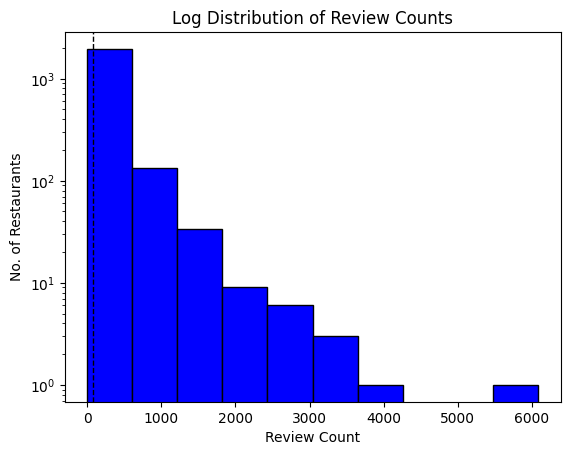

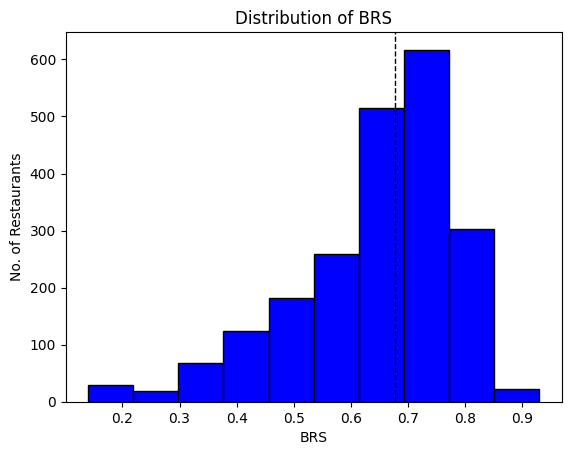

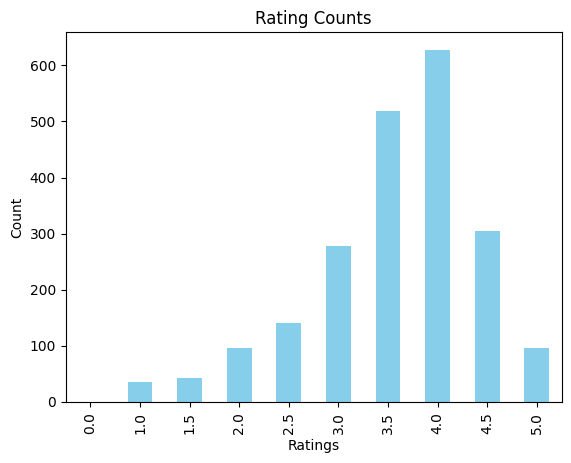

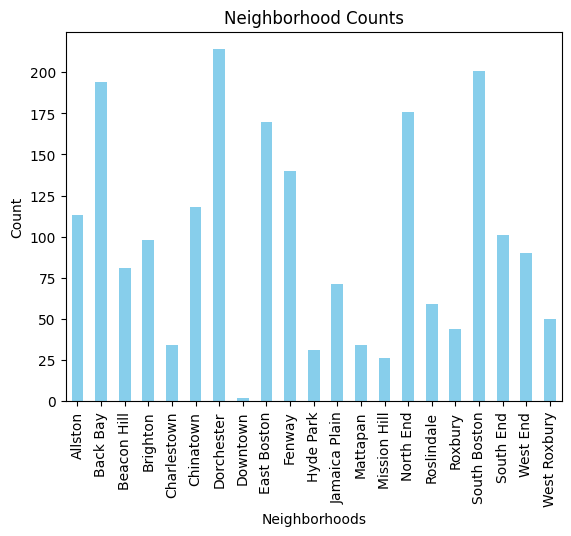

In [2]:
# EDA
'''
- 
- 
- Visualize the sampling per neighborhood
- Distribution of the restaurant tags
- Distribution of the has images, phone, and address
- Distribution of the prices
- Histogram of the calculated score
'''
import matplotlib.pyplot as plt
%matplotlib inline


# Will need to make these graphs more presentable

# Distribution of review count
plt.hist(bus_copy['review_count'], color='blue', edgecolor='black')
plt.axvline(bus_copy['review_count'].median(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('Review Count')
plt.ylabel('No. of Restaurants')
plt.title('Log Distribution of Review Counts')
plt.yscale('log')
plt.show()

# Distribution of balanced rating score
plt.hist(bus_copy['brs'], color='blue', edgecolor='black')
plt.axvline(bus_copy['brs'].median(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('BRS')
plt.ylabel('No. of Restaurants')
plt.title('Distribution of BRS')
plt.show()

# Distribution of rating
rating_counts = bus_copy.loc[:, '0.0':'5.0'].sum()
rating_counts.plot(kind='bar', color='skyblue')
plt.title('Rating Counts')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

# Count of each neighborhood
neighborhood_counts = bus_copy.loc[:, 'Allston':'West Roxbury'].sum()
neighborhood_counts.plot(kind='bar', color='skyblue')
plt.title('Neighborhood Counts')
plt.xlabel('Neighborhoods')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()


affordable_eats       612
mid-range_dining      795
upscale_dining        119
gourmet_experience     33
dtype: int64


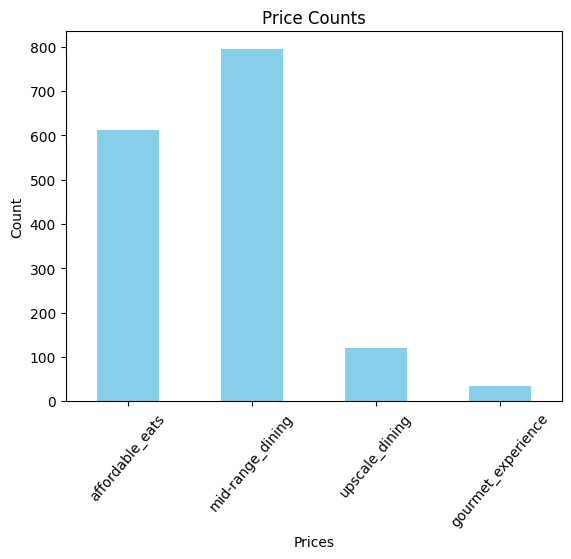

delivery                  1605
pickup                    1151
restaurant_reservation      23
has_image                 2041
has_phone                 1947
has_st_add                2106
has_price                 1559
dtype: int64


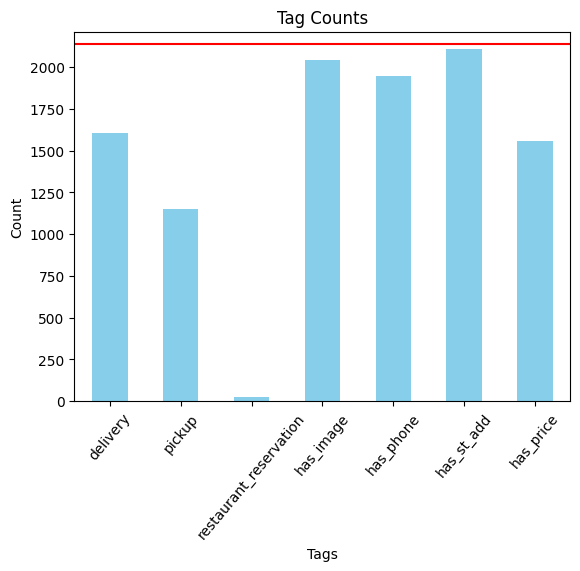

In [3]:
# Counts of prices
price_counts = bus_copy.loc[:, ['affordable_eats', 'mid-range_dining', 'upscale_dining', 'gourmet_experience']].sum()

print(price_counts)

price_counts.plot(kind='bar', color='skyblue')
plt.title('Price Counts')
plt.xlabel('Prices')
plt.ylabel('Count')
plt.xticks(rotation=50)  # Rotate x-axis labels if needed
plt.show()


# Counts of tags
tag_counts = bus_copy.loc[:, ['delivery', 'pickup', 'restaurant_reservation', 'has_image', 'has_phone', 'has_st_add', 'has_price']].sum()

print(tag_counts)

tag_counts.plot(kind='bar', color='skyblue')
plt.axhline(y = bus_copy.shape[0], color = 'r', linestyle = '-')
plt.title('Tag Counts')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.xticks(rotation=50)  # Rotate x-axis labels if needed
plt.show()





/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


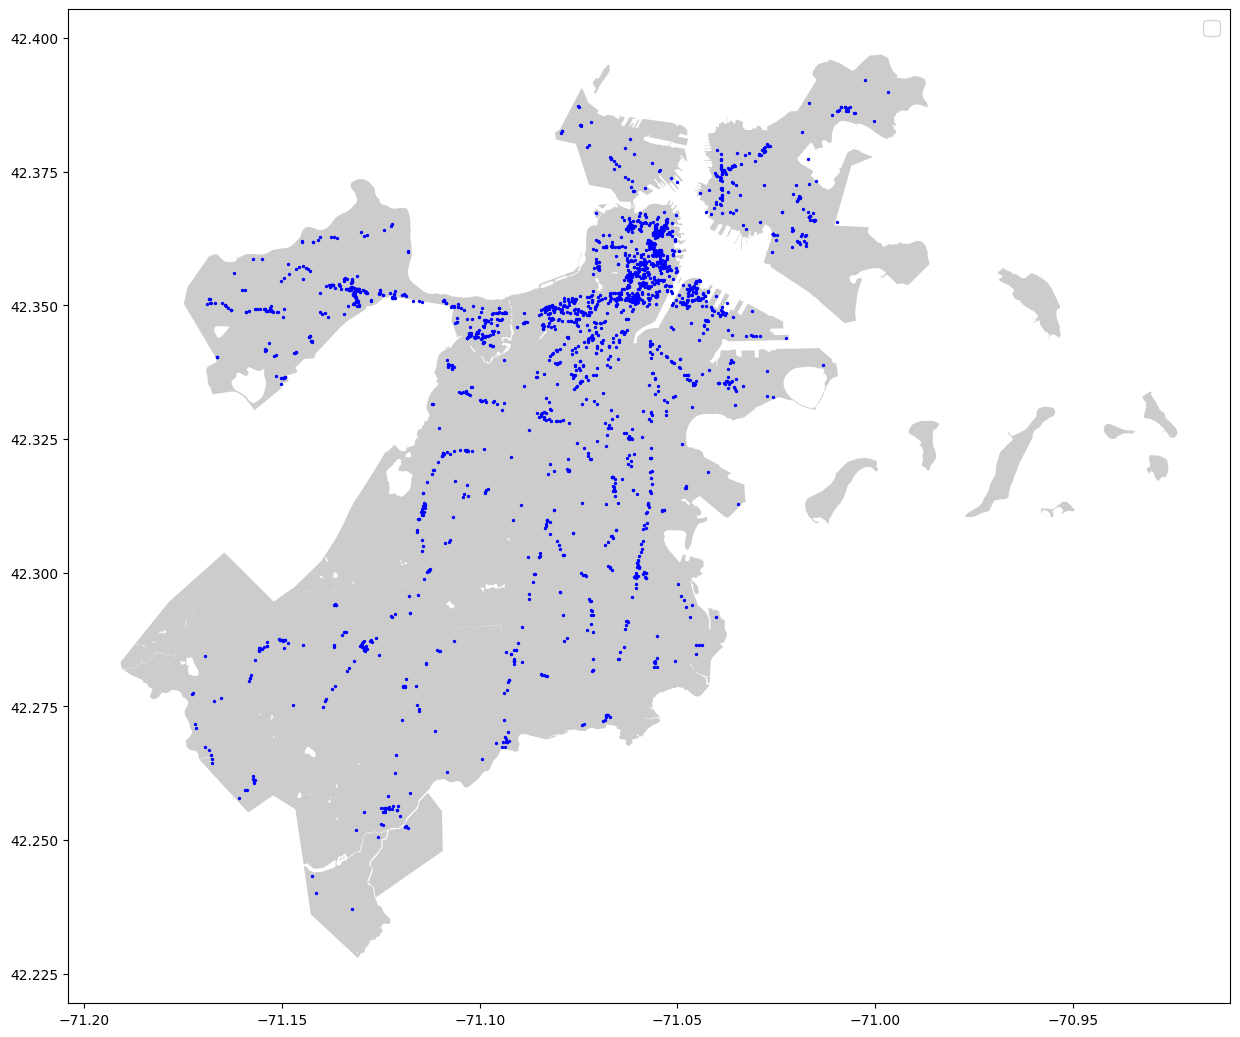

In [4]:
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
from shapely.geometry import Point, Polygon
%matplotlib inline

bos_map = gpd.read_file('City_of_Boston_Boundary/City_of_Boston_Boundary.shp')

geometry = [Point(xy) for xy in zip(bus_copy['longitude'], bus_copy['latitude'])]
crs = {'init':'epsg:4326'}

geo_df = gpd.GeoDataFrame(bus_copy, # specify our data
                          crs=crs, # specify our coordinate reference system
                          geometry=geometry) # specify the geometry list we created

fig, ax = plt.subplots(figsize=(15,15))
bos_map.plot(ax=ax, alpha=0.4, color='grey')

geo_df.plot(ax=ax,
            markersize=2, 
            color='blue', 
            marker='o')


plt.legend(prop={'size':15})

In [ ]:
import folium
geo_df.explore(
    column="neighborhood",  
    tooltip=["name", 'neighborhood', 'id', 'distance', 'zip_code'],
    popup=True,  # show all values in popup (on click)
    tiles="CartoDB positron",  # use "CartoDB positron" tiles
    cmap="Set1",  # use "Set1" matplotlib colormap
)

In [ ]:
#stats = bus_copy.describe().transpose()
bos_map = gpd.read_file('Boston_Neighborhoods/Boston_Neighborhoods.shp')
ax = geoplot.polyplot(bos_map, projection=gcrs.AlbersEqualArea(), zorder=2, figsize=(15, 15))
geoplot.kdeplot(geo_df, cmap='Reds', thresh=0, fill=True, clip=bos_map, ax=ax)


In [ ]:
print(bus_copy['brs'].quantile(0.75))
print(bus_copy['brs'].median())

cuisines = bus_copy.loc[:, 'acaibowls':'wraps'].columns

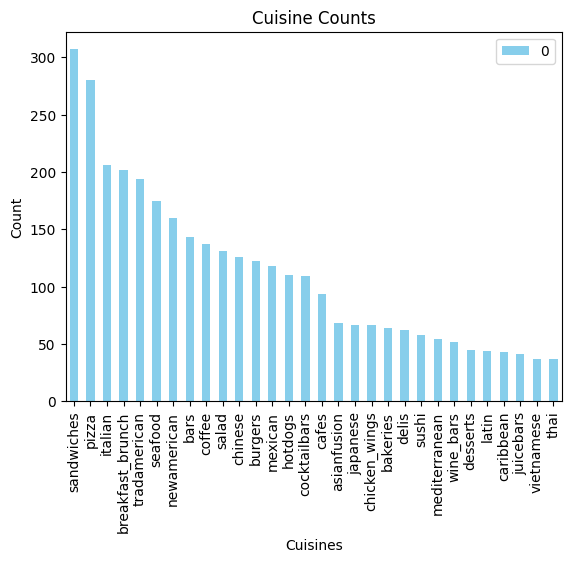

In [9]:
cuisine_counts = (bus_copy.loc[:, 'acaibowls':'wraps'].sum().to_frame()).sort_values([0], ascending = False)

cuisine_counts[:30].plot(kind='bar', color='skyblue')
plt.title('Cuisine Counts')
plt.xlabel('Cuisines')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

# explore the distribution of brs in each feature
# what neighborhoods have the highest mean brs
# next up is machine learning!

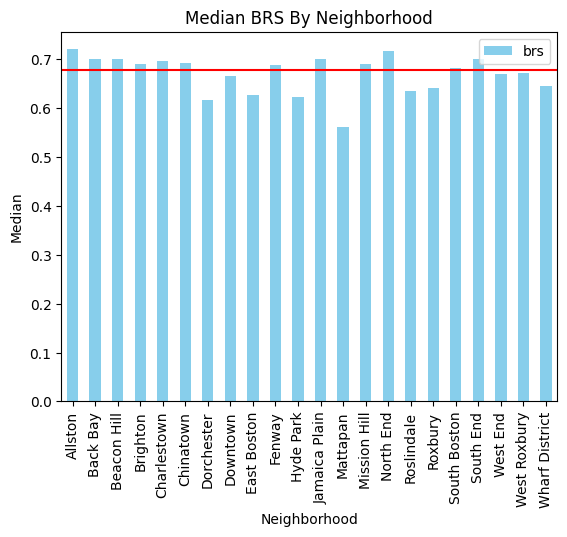

In [30]:
bus_copy.groupby(["neighborhood"])["brs"].median().to_frame().plot(kind='bar', color='skyblue')
plt.axhline(y = bus_copy['brs'].median(), color = 'r', linestyle = '-')
plt.title('Median BRS By Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Median')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()



<AxesSubplot: xlabel='neighborhood'>

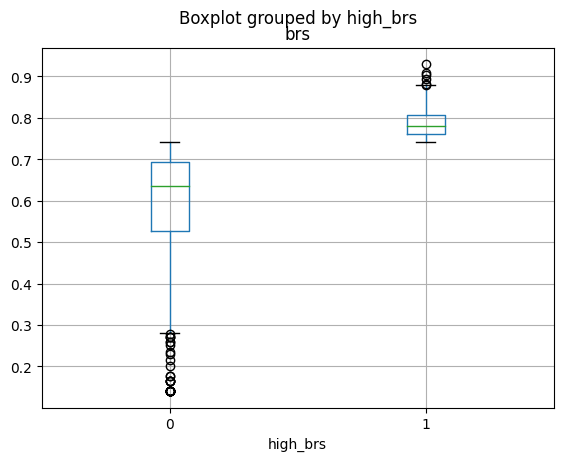

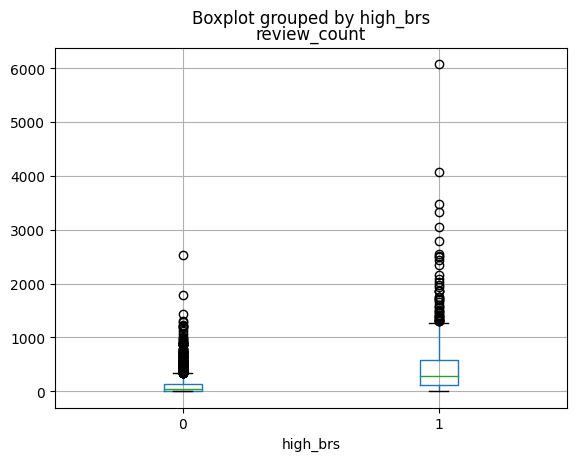

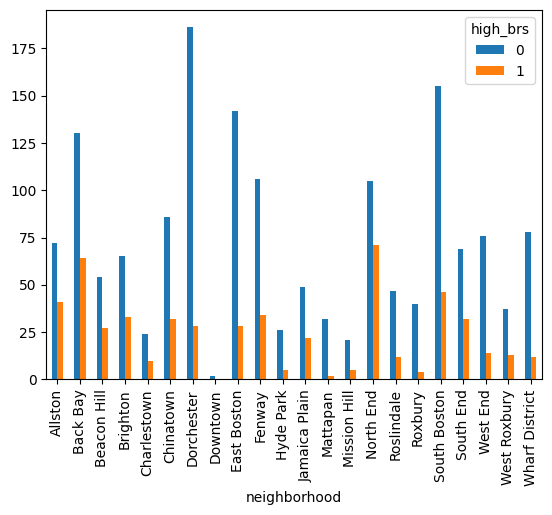

In [5]:
bus_copy.boxplot(column='brs',by='high_brs')
bus_copy.boxplot(column='review_count',by='high_brs')
bus_copy.groupby(['neighborhood', 'high_brs'])['id'].count().unstack('high_brs').plot.bar()



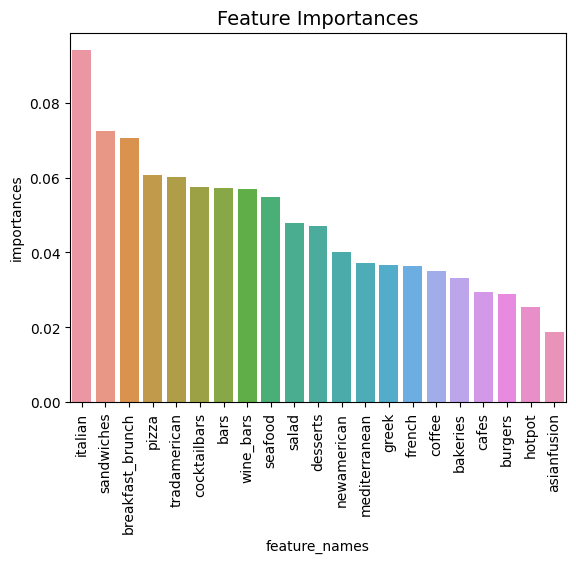

In [44]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

column_names = bus_copy.columns.tolist()

# drop columns that won't be used for machine learning
bus_ml = bus_copy.drop(['distance','id', 'name', 'review_count', 'rating', 'neighborhood', 'latitude', 'longitude',
            'city', 'zip_code', '0.0', '1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0', '4.5', '5.0', 'brs',
              'high_brs', 'East Boston', 'Charlestown', 'Allston', 'Brighton', 'Beacon Hill', 'Back Bay','Chinatown', 'Dorchester',
                'Fenway', 'Hyde Park', 'Jamaica Plain', 'Mattapan', 'Mission Hill','North End', 'Roslindale', 'Roxbury', 'South Boston',
                  'South End', 'West End', 'West Roxbury', 'Wharf District', 'Downtown'], axis=1)

# Splitting data into X (features) and y (target)
y = bus_copy['high_brs']
X = bus_ml

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Creating Random Forest (rf) model with default values
rf = RandomForestClassifier()

# Fitting model to train data
rf.fit(X_train, y_train)

# Obtaining feature importances
rf.feature_importances_

# Feature names
rf.feature_names_in_

# Creating importances_df dataframe
importances_df = pd.DataFrame({"feature_names" : rf.feature_names_in_, 
                               "importances" : rf.feature_importances_})

                      
# keep only the cuisine types
X = bus_ml.loc[:, 'acaibowls':'wraps']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Creating Random Forest (rf) model with default values
rf = RandomForestClassifier()

# Fitting model to train data
rf.fit(X_train, y_train)

# Obtaining feature importances
rf.feature_importances_

# Feature names
rf.feature_names_in_

# Creating importances_df dataframe
importances_df = pd.DataFrame({"feature_names" : rf.feature_names_in_, 
                               "importances" : rf.feature_importances_}).sort_values(['importances'], ascending = False)

limited_importances = (importances_df.sort_values(['importances'], ascending = False))[:21]['feature_names'].values.tolist()




# keep only the highest importance types
X = bus_ml.loc[:, limited_importances]

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Creating Random Forest (rf) model with default values
rf = RandomForestClassifier()

# Fitting model to train data
rf.fit(X_train, y_train)

# Obtaining feature importances
rf.feature_importances_

# Feature names
rf.feature_names_in_

# Creating importances_df dataframe
importances_df = pd.DataFrame({"feature_names" : rf.feature_names_in_, 
                               "importances" : rf.feature_importances_}).sort_values(['importances'], ascending = False)

# Plotting bar chart, g is from graph
g = sns.barplot(x=importances_df["feature_names"], 
                y=importances_df["importances"])
plt.xticks(rotation=90)
g.set_title("Feature Importances", fontsize=14)

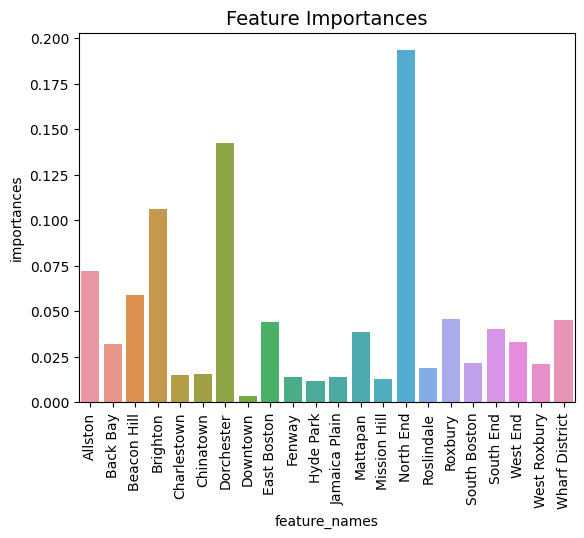

In [32]:

# Looking at the feature importance of a model strictly trained using neighborhoods
# Splitting data into X (features) and y (target)
y = bus_copy['high_brs']
X = bus_ml.loc[:,'Allston':'Wharf District']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Creating Random Forest (rf) model with default values
rf = RandomForestClassifier()

# Fitting model to train data
rf.fit(X_train, y_train)

# Obtaining feature importances
rf.feature_importances_

# Feature names
rf.feature_names_in_

# Creating importances_df dataframe
importances_df = pd.DataFrame({"feature_names" : rf.feature_names_in_, 
                               "importances" : rf.feature_importances_})
# Plotting bar chart, g is from graph
g = sns.barplot(x=importances_df["feature_names"], 
                y=importances_df["importances"])
plt.xticks(rotation=90)
g.set_title("Feature Importances", fontsize=14);    
